In [95]:
%pylab inline
import pandas as pd
from keras.utils import to_categorical

try:
    from nltk.tokenize import sent_tokenize, word_tokenize 
except:
    !pip install -U nltk
    from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

try:
    import gensim 
    from gensim.models import Word2Vec 
except:
    !pip install gensim    
    import gensim 
    from gensim.models import Word2Vec 
    
import nltk
nltk.download('punkt')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation 
from keras.optimizers import Adam

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

'''Import spacy for word2vec encoding, and load model.'''
import spacy
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')

'''For PCA Compression'''
try:
    from sklearn.decomposition import PCA
except:
    !pip install sklearn
    from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /Users/mgb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
'''Read the Data'''

data = pd.read_csv('datasets/google-play-store-apps/googleplaystore.csv')
data = data.dropna(how='any')

In [109]:
data.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [110]:
#After analysing the data types and formats in each column, here's our todo:

to_vectorize = ['App', 'Category', 'Genres', 'Current Ver', 'Android Ver'] #using word2vec
to_oh = ['Type','Content Rating'] #using get_dummies
to_float = ['Rating', 'Reviews', 'Size', 'Installs', 'Price'] #piecemiel - go one-by-one, as all are different formats.
to_mdy = ['Last Updated'] #dateparser + separate to components.

In [113]:
'''Empty DF to which we will append all this stuff ^^ '''
processed = pd.DataFrame(index=data.index)

In [115]:
'''word2vec implementation - ALREADY PERFORMED, WILL TAKE A LONG TIME.'''

#Uncomment if you want to experiment; otherwise just load processed_google_data.csv
'''
for c in to_vectorize:

    column_for_processing = c
    target_dimensions = 3

    print('Encoding words via spacy.nlp for {}'.format(column_for_processing))
    word_vecs = [nlp(i).vector for i in data[column_for_processing]]

    print('Compressing result via PCA')
    '''Compress word2vec to target dimensional size'''

    pca = PCA(n_components=target_dimensions)

    word_vecs_pca = pca.fit_transform(word_vecs)
    
    #Add this, correctly formatted, to the processed df:
    vec_df = pd.DataFrame(word_vecs_pca, columns=['{}_d{}'.format(column_for_processing,i)for i in range(1,target_dimensions+1)])
    processed = processed.join(vec_df)
    print(processed.head())'''

Encoding words via spacy.nlp for App
Compressing result via PCA
     App_d1    App_d2    App_d3
0 -0.934613  0.216938 -0.205248
1 -0.307683  0.094538  1.231061
2 -0.273622  0.814170  0.184246
3 -1.085959 -0.607310 -0.062877
4 -0.906316 -0.087854 -0.018682
Encoding words via spacy.nlp for Category
Compressing result via PCA
     App_d1    App_d2    App_d3  Category_d1  Category_d2  Category_d3
0 -0.934613  0.216938 -0.205248      0.42874     0.869845    -2.640158
1 -0.307683  0.094538  1.231061      0.42874     0.869845    -2.640158
2 -0.273622  0.814170  0.184246      0.42874     0.869845    -2.640158
3 -1.085959 -0.607310 -0.062877      0.42874     0.869845    -2.640158
4 -0.906316 -0.087854 -0.018682      0.42874     0.869845    -2.640158
Encoding words via spacy.nlp for Genres
Compressing result via PCA
     App_d1    App_d2    App_d3  Category_d1  Category_d2  Category_d3  \
0 -0.934613  0.216938 -0.205248      0.42874     0.869845    -2.640158   
1 -0.307683  0.094538  1.231061   

In [117]:
'''Save! That took a while...'''
processed.to_csv('processed_google_data.csv')

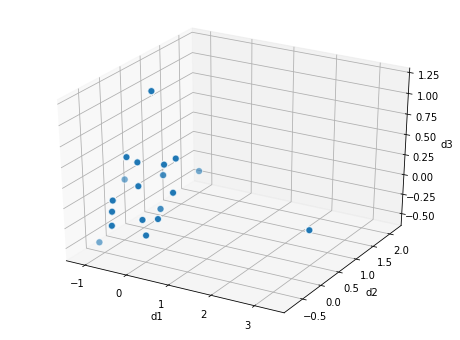

In [118]:
'''Visualize word_2_vec embedding in 3D'''

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x,y,z = list(zip(*word_vecs_pca))

ax.scatter(x, y, z, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')

plt.show()

In [ ]:
'''CONTINUE WITH OH ENCODING HERE.'''

In [ ]:
'''Eventually, train the model below:'''

In [2]:
idx = oh_encoded.index
n = len(idx)

oh_encoded = pd.concat([oh_encoded, data['Rating']], axis=1)

train = oh_encoded.sample(int(.8*n))
valid = oh_encoded.loc[oh_encoded.index.difference(train.index)]

x_train = train[[c for c in train.columns if c != 'Rating']]
y_train = train['Rating']

x_valid = valid[[c for c in valid.columns if c != 'Rating']]
y_valid = valid['Rating']

In [5]:
model = Sequential()

model.add(Dense(64, input_shape=x_train.values[0].shape, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

In [6]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [7]:

model.fit(x_train, y_train, batch_size = 32, epochs = 1, shuffle = True)#, validation_data = (x_valid, y_valid))



Epoch 1/1
7488/7488 [==============================] - 327s 44ms/step - loss: 3.8293


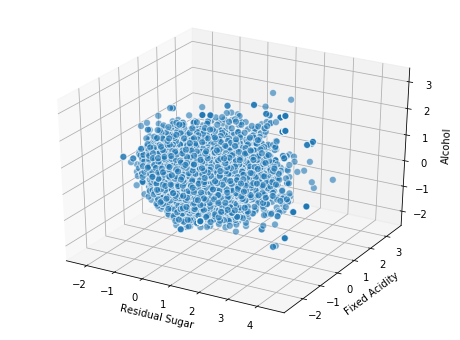